In [1]:
from pybatteryid import ModelStructure
from pybatteryid.identification import identify_model
from pybatteryid.utilities import analyze_dataset, invert_voltage_function, \
    analyze_temperature_soc_space, print_model_details, save_model_to_file
from pybatteryid.plotter import plot_time_vs_temperature, plot_time_vs_current

from data import helper

### Example 6 - Temperature-dependent Model Identification for an NMC Battery

This file contains an example to identify battery models for a 2.85 Ah NMC battery. See [1] for more details.

#### References

[1] Sheikh, A. M. A., M. C. F. Donkers, and Henk Jan Bergveld. "Towards temperature-dependent linear parameter-varying models for lithium-ion batteries using novel experimental design." Journal of Energy Storage 119 (2025): 116311. https://doi.org/10.1016/j.est.2025.116311

#### A. Initialize model structure

In [2]:
# The NMC battery being modelled has the capacity around
# 2.85 Ah. The exact value has been calculated by coulomb-counting
# during GITT experiment. Note that the capacity is in Coulombs.
battery_capacity = 10344.169
sampling_period = 1

model_structure = ModelStructure(battery_capacity, sampling_period)

#### B. Load EMF data

In [3]:
emf_data = helper.load_npy_datasets('data/nmc_with_temperature/gitt_data.npy')
#
model_structure.add_emf_function({'soc_values': emf_data['soc_values'],
                                  'voltage_values': emf_data['voltage_values'],
                                  'dVdT_values': emf_data['dVoltage_dTemperature_values'],
                                  'reference_temperature_value': emf_data['reference_temperature_value']})

#### C. Add basis functions

By default, the characters `s`, `i`, `d`, and `v` are reserved for SOC, current, current-direction and voltage. Additionally, the operations `⁻¹`, `log[`$\cdot$`]`, `exp[`$\gamma$`sqrt[|`$\cdot$`|]]`, `d[`$\cdot$`,`$\cdot$`]` are detected automatically.

In [4]:
model_structure.add_basis_functions(
    [ 'd[0.01,0.99]', 's', 'exp[[0.5*s]]', 'exp[0.05*sqrt[|i|]]', 'exp[[0.00366*T+1]^-1]' ]
)

#### D. Load identification dataset

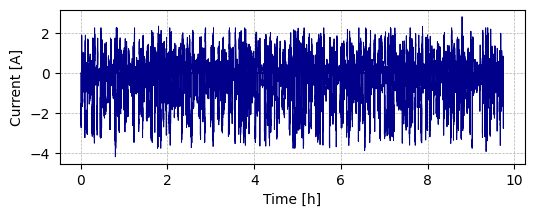

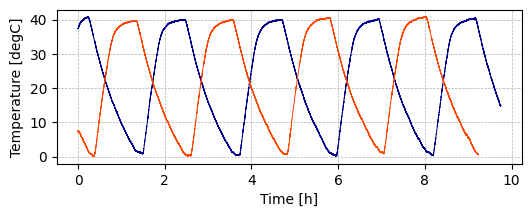

In [5]:
# 
datasets = helper.load_npy_datasets(['data/nmc_with_temperature/identification_data_2_6.npy',
                                     'data/nmc_with_temperature/identification_data_5_6.npy'])
#
plot_time_vs_current([(datasets[0]['time_values'] / 3600, datasets[0]['current_values'])],
                         figsize=(6, 2), units=('h', 'A'),
                         colors=['darkblue', 'orangered'])
plot_time_vs_temperature([(dataset['time_values'] / 3600, dataset['temperature_values']) for dataset in datasets],
                         figsize=(6, 2), units=('h', 'degC'),
                         colors=['darkblue', 'orangered', 'green'])

We determine the initial SOC for each dataset by inverting the EMF function.

In [6]:
initial_socs = []
for dataset in datasets:
    initial_socs.append(invert_voltage_function(model_structure.emf_function,
                                                dataset['voltage_values'][0],
                                                dataset['temperature_values'][0]) )

We add the initial SOCs to the datasets.

In [7]:
identification_datasets = [{'initial_soc': soc,
                            'time_values': dataset['time_values'],
                            'current_values': dataset['current_values'],
                            'voltage_values': dataset['voltage_values'],
                            'temperature_values': dataset['temperature_values']} for soc, dataset in zip(initial_socs, datasets)]

We analyze the datasets to get a better idea of the corresponding information content.

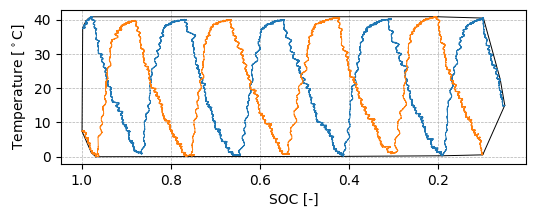

                 Dataset analysis                  
┌────────────────────────────┬────────────────────┐
│ Number of samples          │ 35103              │
│ Experiment time [s], [h]   │ 35102.000, 9.751   │
│ Extracted charge [C], [Ah] │ 9807.274, 2.72424  │
│ Initial voltage [V]        │ 4.19383            │
│ Voltage range [V]          │ (2.53525, 4.23930) │
│ SOC range [%]              │ (4.99, 99.79)      │
│ Temperature range [°C]     │ (0.03, 40.80)      │
└────────────────────────────┴────────────────────┘

                 Dataset analysis                  
┌────────────────────────────┬────────────────────┐
│ Number of samples          │ 33261              │
│ Experiment time [s], [h]   │ 33260.000, 9.239   │
│ Extracted charge [C], [Ah] │ 9314.736, 2.58743  │
│ Initial voltage [V]        │ 4.19547            │
│ Voltage range [V]          │ (2.54374, 4.31259) │
│ SOC range [%]              │ (9.90, 99.94)      │
│ Temperature range [°C]     │ (-0.06, 40.83)     │
└────────────────────────────┴────────────────────┘

In [8]:
analyze_temperature_soc_space(identification_datasets, battery_capacity, sampling_period, model_structure.emf_function)

for dataset in identification_datasets:
    analyze_dataset(dataset, battery_capacity, sampling_period, model_structure.emf_function)

#### E. Identify a battery model

We identify a battery model for given model order $n$ and nonlinearity order $l$.

In [9]:
#
model = identify_model(identification_datasets, model_structure,
                       model_order=3, nonlinearity_order=3,
                       optimizers=['lassocv.sklearn', 'ridgecv.sklearn'],
                       combining_strategy='interleave')

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Inverse condition number of regression matrix: 7.588088423166045e-19                                            │
│ Dimensions of regression matrix: (35100 rows, 350 columns)                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Performing cross-validated LASSO using `sklearn` package.                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

........................................

Solution found using lambda_1 = 2 * alpha * n_samples = 1.00

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Performing cross-validated Ridge regression using `sklearn` package.                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Solution found using lambda_2 = alpha = 0.001

#### F. Print Model Details

In [10]:
#
print_model_details(model)

                       Model order = 3; Nonlinearity order = 3; Number of model terms = 173                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Model Term                                                                             ┃ Estimated Parameter    ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ v(k-1)                                                                                 │ 0.051857527507540364   │
│ v(k-1)×d[0.01,0.99](k-1)                                                               │ 0.17374499321845918    │
│ v(k-1)×exp[[0.5*s]](k-1)                                                               │ 0.06198171191286147    │
│ v(k-1)×exp[[0.00366*T+1]^-1](k-1)                                                      │ 0.02136894929198313    │
│ v(k-1)×d[0.01,0.99](k-1)×exp[[0.00366*T+1]^-1](k-1)                                    │ 0.22638151175513216    │
│ v(k-1)×s(k-1)×exp[[0.00366*T+1]^-1](k-1)                                               │ -0.149108979033634     │
│ v(k-1)×exp[[0.00366*T+1]^-1](k-1)×exp[[0.00366*T+1]^-1](k-1)                           │ -0.29735104783519983   │
│ v(k-1)×d[0.01,0.99](k-1)×s(k-1)×exp[[0.00366*T+1]^-1](k-1)                             │ 0.05181324031693518    │
│ v(k-1)×d[0.01,0.99](k-1)×exp[[0.5*s]](k-1)×exp[[0.00366*T+1]^-1](k-1)                  │ -0.08079319323184168   │
│ v(k-1)×d[0.01,0.99](k-1)×exp[0.05*sqrt[|i|]](k-1)×exp[[0.00366*T+1]^-1](k-1)           │ -0.27938559261198853   │
│ v(k-1)×d[0.01,0.99](k-1)×exp[[0.00366*T+1]^-1](k-1)×exp[[0.00366*T+1]^-1](k-1)         │ 0.025738578545288306   │
│ v(k-1)×s(k-1)×exp[[0.5*s]](k-1)×exp[[0.00366*T+1]^-1](k-1)                             │ 0.546569692776148      │
│ v(k-1)×s(k-1)×exp[[0.00366*T+1]^-1](k-1)×exp[[0.00366*T+1]^-1](k-1)                    │ -0.34647025024033623   │
│ v(k-1)×exp[[0.5*s]](k-1)×exp[0.05*sqrt[|i|]](k-1)×exp[[0.00366*T+1]^-1](k-1)           │ -0.5357146144634143    │
│ v(k-1)×exp[[0.5*s]](k-1)×exp[[0.00366*T+1]^-1](k-1)×exp[[0.00366*T+1]^-1](k-1)         │ 0.22934742570384586    │
│ v(k-1)×exp[0.05*sqrt[|i|]](k-1)×exp[[0.00366*T+1]^-1](k-1)×exp[[0.00366*T+1]^-1](k-1)  │ 0.38931357294960806    │
│ v(k-2)                                                                                 │ 0.1613074071331637     │
│ v(k-2)×exp[[0.5*s]](k-2)                                                               │ 0.13522604100898708    │
│ v(k-2)×exp[[0.00366*T+1]^-1](k-2)                                                      │ 0.2938703968619387     │
│ v(k-2)×d[0.01,0.99](k-2)×exp[[0.00366*T+1]^-1](k-2)                                    │ -0.0003269080461518213 │
│ v(k-2)×exp[[0.5*s]](k-2)×exp[[0.00366*T+1]^-1](k-2)                                    │ 0.1352049639221538     │
│ v(k-2)×exp[0.05*sqrt[|i|]](k-2)×exp[[0.00366*T+1]^-1](k-2)                             │ -0.06318265314256541   │
│ v(k-2)×exp[[0.00366*T+1]^-1](k-2)×exp[[0.00366*T+1]^-1](k-2)                           │ 0.3957037032950966     │
│ v(k-2)×s(k-2)×exp[[0.00366*T+1]^-1](k-2)×exp[[0.00366*T+1]^-1](k-2)                    │ 0.20055210944272453    │
│ v(k-2)×exp[[0.5*s]](k-2)×exp[[0.00366*T+1]^-1](k-2)×exp[[0.00366*T+1]^-1](k-2)         │ -0.3495565186797107    │
│ v(k-2)×exp[0.05*sqrt[|i|]](k-2)×exp[[0.00366*T+1]^-1](k-2)×exp[[0.00366*T+1]^-1](k-2)  │ -0.14048639509368563   │
│ v(k-2)×exp[[0.00366*T+1]^-1](k-2)×exp[[0.00366*T+1]^-1](k-2)×exp[[0.00366*T+1]^-1](k-… │ -0.025560975983245353  │
│ v(k-3)×d[0.01,0.99](k-3)×exp[[0.00366*T+1]^-1](k-3)                                    │ -0.2346209003032855    │
│ v(k-3)×exp[[0.00366*T+1]^-1](k-3)×exp[[0.00366*T+1]^-1](k-3)                           │ 0.38415674341219946    │
│ v(k-3)×d[0.01,0.99](k-3)×exp[[0.5*s]](k-3)×exp[[0.00366*T+1]^-1](k-3)                  │ -0.006535275581566039  │
│ v(k-3)×d[0.01,0.99](k-3)×exp[0.05*sqrt[|i|]](k-3)×exp[

#### G. Save Model to File

In [11]:
save_model_to_file(model, 'results/nmc_with_temperature', 'model')